Forest Cover Type Prediction<br>
w205 - Applied Machine Learning <br>
RanForest - Anu, Lina, Naga, Rishi

#### Agenda
- Introduction
- EDA - Data Distribution and Correlation
- Data Transformation and Feature Engineering
- Model Selection and Training
- Optimization and Error Analysis 
- Cross-validation, overfitting/underfitting
- Conclusion

#### 1. Introduction

Natural resources are key to keep a balance in the ecological life cycle. A larger goal of this project is to map out various type of tree populations in different regions and how deforestation through natural causes like a forest fire or human activities create sustainable environmental impact. <br>

For this project, we are using Roosevelt National Forest data as this area is considered to be unaffected by the artificial causes. Once the team achieves a satisfactory level of accuracy, the model will be used in various geological and biological research projects by the federal government and non-profit organizations. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings; warnings.simplefilter('ignore')

import random
random.seed(1)

#### 2. EDA - Data Statistic and Distribution

In [2]:
# Get input data

input_all = pd.read_csv("./input/train.csv")
input_test = pd.read_csv("./input/test.csv")

In [3]:
# Split input data from the labels
train_data_all = input_all.iloc[:, input_all.columns != 'Cover_Type']
train_label_all = input_all.iloc[:, input_all.columns == 'Cover_Type']


In [4]:
# Identify the shape of the data
print(train_data_all.shape)

(15120, 55)


The number of samples are good enough to conduct the analysis. However, the number of features should go through a selection process to avoid noise.

In [5]:
train_data, dev_data, train_label, dev_label = train_test_split(train_data_all, train_label_all, test_size=0.2, stratify = train_label_all)

In [6]:
print(train_data.shape, dev_data.shape)

(12096, 55) (3024, 55)


In [7]:
# Get data distribution
train_desc = train_data.describe()
train_desc

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,...,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000
mean,7578.207341,2749.289435,156.595734,16.480903,226.163938,50.968667,1715.299438,212.594990,218.885086,135.172371,...,0.021908,0.045718,0.040592,0.001323,0.006779,0.000827,0.002563,0.047371,0.041915,0.030589
std,4363.800804,417.079231,110.409556,8.474047,208.646593,61.268040,1327.427140,30.587259,22.755370,45.895333,...,0.146389,0.208881,0.197351,0.036347,0.082059,0.028742,0.050562,0.212440,0.200403,0.172207
min,1.000000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3798.750000,2375.000000,64.000000,10.000000,67.000000,5.000000,765.000000,196.000000,207.000000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7598.000000,2750.500000,125.000000,15.000000,180.000000,32.000000,1317.000000,220.000000,222.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11364.250000,3103.000000,261.000000,22.000000,330.000000,79.000000,2256.000000,235.000000,235.000000,167.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15120.000000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6836.000000,254.000000,254.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- No missing values found 
- the categorical variables are already one hot encoded
- Id column can be dropped as it contains row number
- A number of columns have zero or negative values. Rescaling them should help during data transformation.

##### Variable distribution

In [8]:

def hstContVariables(varName):
    # the histogram of the data
    plt.hist(train_data[varName], 50, density=True, facecolor='g', alpha=0.75)

    plt.xlabel('value')
    plt.ylabel('frequency')
    plt.title(varName + ' Data')
    #plt.text(train_desc[:]['Elevation']['min'], 0.001, '$\mu={0},\ \sigma={1}$'.format(train_desc[:]['Elevation']['mean'], train_desc[:]['Elevation']['std']))
    #plt.axis([train_desc[:][varName].min, train_desc[:][varName].max, 0, 0.0015])
    plt.grid(True)
    plt.show()

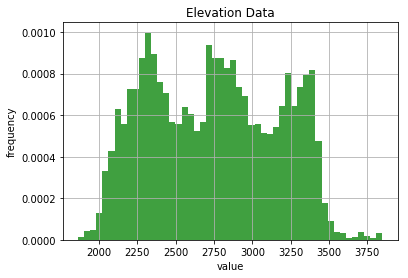

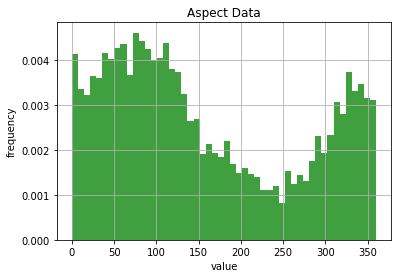

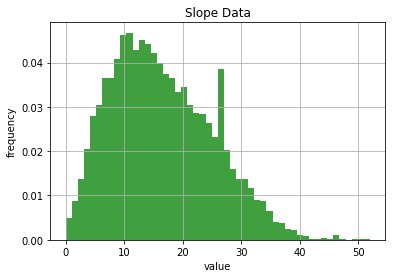

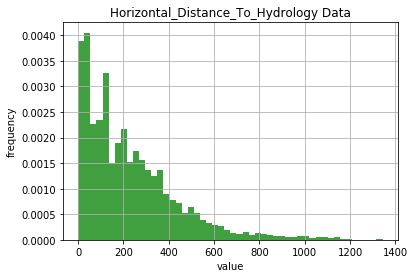

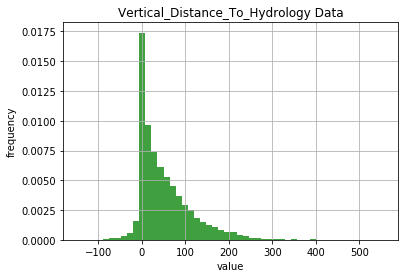

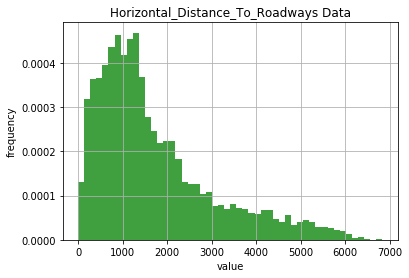

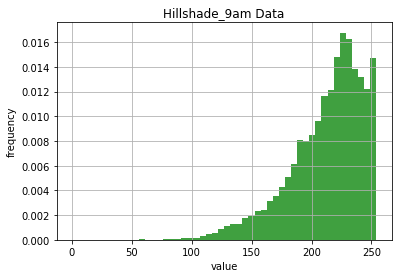

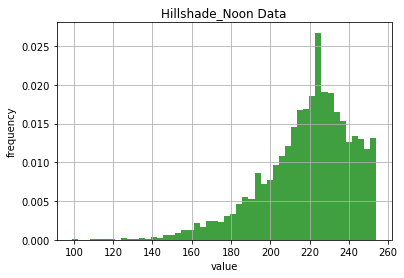

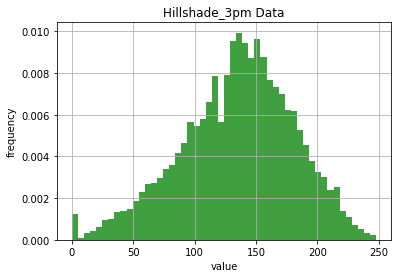

In [9]:
hstContVariables('Elevation')
hstContVariables('Aspect')
hstContVariables('Slope')
hstContVariables('Horizontal_Distance_To_Hydrology')
hstContVariables('Vertical_Distance_To_Hydrology')
hstContVariables('Horizontal_Distance_To_Roadways')
hstContVariables('Hillshade_9am')
hstContVariables('Hillshade_Noon')
hstContVariables('Hillshade_3pm')

#If the data distribution is not normal (multiple modal or skewed), taking logs might help to get in a normalized form.

#### 2. Data Transformation and Feature Engineering

In [10]:
# Drop Id column
train_data_m = train_data.drop(['Id'], axis=1)
train_data_m.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
3452,2880,170,19,120,25,366,230,244,137,1032,...,0,0,0,0,0,0,0,0,0,0
2950,3285,206,11,450,58,4124,213,250,171,2188,...,0,0,0,0,0,0,0,0,0,0
1590,2733,93,28,150,85,162,250,185,44,2418,...,0,0,0,0,0,0,0,0,0,0
387,2671,109,26,175,55,1350,253,200,58,664,...,0,0,0,0,0,0,0,0,0,0
14333,3143,139,9,573,106,1950,234,238,135,914,...,0,1,0,0,0,0,0,0,0,0


Check variability of each variable and if the standard deviation falls under a threshold, those variables should be removed.

In [11]:
for i in range(len(train_data_m.columns)):
    sd = train_desc[train_data_m.columns[i]]['std']
    if sd < 0.01:
        print(train_data_m.columns[i] + ' - ' + str(sd))

Soil_Type7 - 0.0
Soil_Type8 - 0.009092412093166856
Soil_Type15 - 0.0
Soil_Type25 - 0.009092412093167869


In [12]:
#Drop columns with low variability
sol_types_to_remove = ['Soil_Type7', 'Soil_Type15', 'Soil_Type25']
train_data_m = train_data_m.drop(sol_types_to_remove, axis = 1)
train_data_m.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
3452,2880,170,19,120,25,366,230,244,137,1032,...,0,0,0,0,0,0,0,0,0,0
2950,3285,206,11,450,58,4124,213,250,171,2188,...,0,0,0,0,0,0,0,0,0,0
1590,2733,93,28,150,85,162,250,185,44,2418,...,0,0,0,0,0,0,0,0,0,0
387,2671,109,26,175,55,1350,253,200,58,664,...,0,0,0,0,0,0,0,0,0,0
14333,3143,139,9,573,106,1950,234,238,135,914,...,0,1,0,0,0,0,0,0,0,0


In [13]:
# Determine variables with high skewness and remove those which are crossing the threshold

cols_to_remove = []
skew_num = train_data_m.skew()
for c in train_data_m.columns:
    if skew_num[c] > 15 or skew_num[c] < -15:       
        cols_to_remove = c
        
train_data_m = train_data_m.drop(cols_to_remove, axis = 1)


Determine sample counts of each category. Normalization is required for imbalance distribution.

In [14]:
train_label.groupby('Cover_Type').size()

Cover_Type
1    1728
2    1728
3    1728
4    1728
5    1728
6    1728
7    1728
dtype: int64

Cover types are evenly distributed in data

In [15]:
def getHighlyCorrFeatures(corr, thresold):
    # Get highly correlated features pairs
    feature_corr_coef = {}

    for i in range(corr.shape[0]):
        for j in range(corr.shape[0]):
            if i != j and (corr[corr_features[i]][corr_features[j]] > thresold or corr[corr_features[i]][corr_features[j]] < (thresold * -1)):
                if corr_features[j] + '-' + corr_features[i] in feature_corr_coef:
                    continue
                else:
                    feature_corr_coef[corr_features[i] + '-' + corr_features[j]] = corr[corr_features[i]][corr_features[j]]


    print(feature_corr_coef)
    
    return feature_corr_coef

In [16]:
# Correlations
# Features with high correlation can be reduced, since multiple highly correlated features do not add to model effectiveness
corr_features = ['Elevation','Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', \
                 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', \
                 'Horizontal_Distance_To_Fire_Points']
input_corr = train_data_m[corr_features]

corr = input_corr.corr()
getHighlyCorrFeatures(corr, 0.8)

corr.style.background_gradient(cmap='coolwarm')

{}


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
Elevation,1,-0.0153886,-0.307324,0.409565,0.119698,0.57946,0.101224,0.215577,0.0846826,0.448281
Aspect,-0.0153886,1,0.0358892,0.0411077,0.0573361,0.0614266,-0.597549,0.318883,0.633917,-0.050998
Slope,-0.307324,0.0358892,1,-0.053022,0.267533,-0.275623,-0.201936,-0.613484,-0.325503,-0.239797
Horizontal_Distance_To_Hydrology,0.409565,0.0411077,-0.053022,1,0.649599,0.205717,-0.0296526,0.0816099,0.077019,0.162607
Vertical_Distance_To_Hydrology,0.119698,0.0573361,0.267533,0.649599,1,0.0119488,-0.0912807,-0.134421,-0.0406229,-0.0144042
Horizontal_Distance_To_Roadways,0.57946,0.0614266,-0.275623,0.205717,0.0119488,1,-0.000958279,0.241436,0.171232,0.491159
Hillshade_9am,0.101224,-0.597549,-0.201936,-0.0296526,-0.0912807,-0.000958279,1,-0.014478,-0.780774,0.0751888
Hillshade_Noon,0.215577,0.318883,-0.613484,0.0816099,-0.134421,0.241436,-0.014478,1,0.614844,0.126625
Hillshade_3pm,0.0846826,0.633917,-0.325503,0.077019,-0.0406229,0.171232,-0.780774,0.614844,1,0.0471387
Horizontal_Distance_To_Fire_Points,0.448281,-0.050998,-0.239797,0.162607,-0.0144042,0.491159,0.0751888,0.126625,0.0471387,1


None of those correlations are high enough to be replacable.

In [17]:
#Check the correlation between the output/input variables. 

pd.concat([input_corr,train_label],axis=1).corr()['Cover_Type']

#All the variables have at least some degree of correlation with the output variable

Elevation                             0.017732
Aspect                                0.003683
Slope                                 0.084153
Horizontal_Distance_To_Hydrology     -0.006806
Vertical_Distance_To_Hydrology        0.074480
Horizontal_Distance_To_Roadways      -0.104468
Hillshade_9am                        -0.008697
Hillshade_Noon                       -0.099192
Hillshade_3pm                        -0.054364
Horizontal_Distance_To_Fire_Points   -0.094280
Cover_Type                            1.000000
Name: Cover_Type, dtype: float64

In [18]:
train_data_m.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type38,Soil_Type39,Soil_Type40
count,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,...,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000
mean,2749.289435,156.595734,16.480903,226.163938,50.968667,1715.299438,212.594990,218.885086,135.172371,1518.730407,...,0.047288,0.021908,0.045718,0.040592,0.001323,0.006779,0.000827,0.047371,0.041915,0.030589
std,417.079231,110.409556,8.474047,208.646593,61.268040,1327.427140,30.587259,22.755370,45.895333,1101.620088,...,0.212264,0.146389,0.208881,0.197351,0.036347,0.082059,0.028742,0.212440,0.200403,0.172207
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2375.000000,64.000000,10.000000,67.000000,5.000000,765.000000,196.000000,207.000000,106.000000,732.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2750.500000,125.000000,15.000000,180.000000,32.000000,1317.000000,220.000000,222.000000,138.000000,1266.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3103.000000,261.000000,22.000000,330.000000,79.000000,2256.000000,235.000000,235.000000,167.000000,1996.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6836.000000,254.000000,254.000000,248.000000,6993.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Baseline Models

In [19]:
print('NB ------------------------')
model = GaussianNB()
model.fit(train_data, train_label)
result1 = model.score(dev_data, dev_label)
print(result1)

print('KNN ------------------------')
model2 = KNeighborsClassifier()
model2.fit(train_data, train_label)
result2 = model2.score(dev_data, dev_label)
print(result2)

print('RF -------------------------')
model3 = RandomForestClassifier()
model3.fit(train_data, train_label)
result3 = model3.score(dev_data, dev_label)
print(result3)

print('LR -------------------------')
model4 = LogisticRegression()
model4.fit(train_data, train_label)
result4 = model4.score(dev_data, dev_label)
print(result4)

NB ------------------------
0.6455026455026455
KNN ------------------------
0.8316798941798942
RF -------------------------
0.8492063492063492
LR -------------------------
0.6633597883597884


#### Dimentionality Reduction and Model Performance Tuning

In [20]:
dev_data_m = dev_data.drop(['Id', 'Soil_Type7', 'Soil_Type15', 'Soil_Type25'], axis = 1)
dev_data_m = dev_data_m.drop(cols_to_remove, axis = 1)

In [21]:
print('NB ------------------------')
model = GaussianNB()
model.fit(train_data_m, train_label)
result1 = model.score(dev_data_m, dev_label)
print(result1)

print('KNN ------------------------')
model2 = KNeighborsClassifier()
model2.fit(train_data_m, train_label)
result2 = model2.score(dev_data_m, dev_label)
print(result2)

print('RF ------------------------')
model3 = RandomForestClassifier(n_estimators = 100)
model3.fit(train_data_m, train_label)
result3 = model3.score(dev_data_m, dev_label)
print(result3)

print('LR ------------------------')
model4 = LogisticRegression()
model4.fit(train_data_m, train_label)
result4 = model4.score(dev_data_m, dev_label)
print(result4)

NB ------------------------
0.5896164021164021
KNN ------------------------
0.8108465608465608
RF ------------------------
0.8607804232804233
LR ------------------------
0.6656746031746031


After the data transformation the models seem to perform poorly, except rf. Why??